In [13]:
import pickle
import time

from gep_config_parser import *
from data_wrangling import dataframe_to_dict

from primal_dual import PrimalDualTrainer
from gep_problem import GEPProblemSet
from gep_problem_operational import GEPOperationalProblemSet
from get_gurobi_vars import OptValueExtractor
from gep_main import run_model_no_bounds as run_Gurobi_no_bounds

CONFIG_FILE_NAME        = "config.toml"
VISUALIZATION_FILE_NAME = "visualization.toml"


SCALE_FACTORS = {
    "pDemand": 1/1000,  # MW -> GW
    "pGenAva": 1,       # Don't scale
    "pVOLL": 1/1000,         # kEUR/MWh -> mEUR/GWh
    "pWeight": 1,       # Don't scale
    "pRamping": 1,      # Don't scale
    "pInvCost": 1/1000,      # kEUR/MW -> mEUR/GW
    "pVarCost": 1/1000,      # kEUR/MWh -> mEUR/GWh
    "pUnitCap": 1/1000, # MW -> GW
    "pExpCap": 1/1000,  # MW -> GW
    "pImpCap": 1/1000,  # MW -> GW
}

def scale_dict(data_dict, scale_factor):
    return {key: value * scale_factor for key, value in data_dict.items()}


def prep_data(args, inputs, target_path):
    print("Wrangling the input data")

    # Extract sets
    T = inputs["times"] # [1, 2, 3, ... 8760] ---> 8760
    N = args["N"]
    G = args["G"]
    L = args["L"]

    if not (N or G or L):
        G = inputs["generators"] # [('Country1', 'EnergySource1'), ...] ---> 107
        L = inputs["transmission_lines"] # [('Country1', 'Country2'), ...] ---> 44
        N = inputs["nodes"] # ['Country1', 'Country2', ...] ---> 20
    else:
        # Convert to tuples
        # N = [tuple(pair) for pair in N]
        G = [tuple(pair) for pair in G]
        L = [tuple(pair) for pair in L]

    # Extract time series data
    pDemand = dataframe_to_dict(
        inputs["demand_data"],
        keys=["Country", "Time"],
        value="Demand_MW"
    )
    
    pGenAva = dataframe_to_dict(
        inputs["generation_availability_data"],
        keys=["Country", "Technology", "Time"],
        value="Availability_pu"
    )

    # Extract scalar parameters
    pVOLL = inputs["value_of_lost_load"]

    # WOP
    # Scale inversely proportional to times (T)
    pWeight = inputs["representative_period_weight"] / (args["sample_duration"] / 8760)

    pRamping = inputs["ramping_value"]

    # Extract generator parameters
    pInvCost = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="InvCost_kEUR_MW_year"
    )

    pVarCost = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="VarCost_kEUR_per_MWh"
    )

    pUnitCap = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="UnitCap_MW"
    )

    # Extract line parameters
    pExpCap = dataframe_to_dict(
        inputs["transmission_lines_data"],
        keys=["CountryA", "CountryB"],
        value="ExpCap_MW"
    )

    pImpCap = dataframe_to_dict(
        inputs["transmission_lines_data"],
        keys=["CountryA", "CountryB"],
        value="ImpCap_MW"
    )

    if args["scale_problem"]:
        pDemand = scale_dict(pDemand, SCALE_FACTORS["pDemand"])
        pGenAva = scale_dict(pGenAva, SCALE_FACTORS["pGenAva"])
        pVOLL *= SCALE_FACTORS["pVOLL"]
        pWeight *= SCALE_FACTORS["pWeight"]
        pRamping *= SCALE_FACTORS["pRamping"]
        pInvCost = scale_dict(pInvCost, SCALE_FACTORS["pInvCost"])
        pVarCost = scale_dict(pVarCost, SCALE_FACTORS["pVarCost"])
        pUnitCap = scale_dict(pUnitCap, SCALE_FACTORS["pUnitCap"])
        pExpCap = scale_dict(pExpCap, SCALE_FACTORS["pExpCap"])
        pImpCap = scale_dict(pImpCap, SCALE_FACTORS["pImpCap"])

    
    print(pVOLL * pWeight)
    print(pVarCost[('GER', 'SunPV')] * pWeight)


    # We need to sort the dictionaries for changing to tensors!
    pDemand = dict(sorted(pDemand.items()))
    pGenAva = dict(sorted(pGenAva.items()))
    pInvCost = dict(sorted(pInvCost.items()))
    pVarCost = dict(sorted(pVarCost.items()))
    pUnitCap = dict(sorted(pUnitCap.items()))
    pExpCap = dict(sorted(pExpCap.items()))
    pImpCap = dict(sorted(pImpCap.items()))

    time_ranges = [range(i, i + args["sample_duration"], 1) for i in range(1, len(T), args["sample_duration"])]

    if not os.path.exists(target_path):
        extractor = OptValueExtractor(args["operational"])
        for t in time_ranges:
            model, solver, time_taken = run_Gurobi_no_bounds(experiment_instance,
                        t,
                        N,
                        G,
                        L,
                        pDemand,
                        pGenAva,
                        pVOLL,
                        pWeight,
                        pRamping,
                        pInvCost,
                        pVarCost,
                        pUnitCap,
                        pExpCap,
                        pImpCap,
                        )
            extractor.extract_values(model)

        with open(target_path, 'wb') as f:
            pickle.dump(extractor.opt_targets, f)


    print("Creating problem instance")
    if args["operational"]:
        data = GEPOperationalProblemSet(args, T, N, G, L, pDemand, pGenAva, pVOLL, pWeight, pRamping, pInvCost, pVarCost, pUnitCap, pExpCap, pImpCap, target_path=target_path)
    else:
        data = GEPProblemSet(args, T, N, G, L, pDemand, pGenAva, pVOLL, pWeight, pRamping, pInvCost, pVarCost, pUnitCap, pExpCap, pImpCap, target_path=target_path)

    return data

def run_PDL(data, args, save_dir):
    # Run PDL
    print("Training the PDL")
    trainer = PrimalDualTrainer(data, args, save_dir)
    primal_net, dual_net, stats = trainer.train_PDL()
    return primal_net, dual_net

if __name__ == "__main__":
    import json

    ## Step 1: parse the input data
    print("Parsing the config file")

    data = parse_config(CONFIG_FILE_NAME)
    experiment = data["experiment"]
    outputs_config = data["outputs_config"]

    with open("config.json", "r") as file:
        args = json.load(file)
    
    print(args)

    # Train the model:
    for i, experiment_instance in enumerate(experiment["experiments"]):
        # Setup output dataframe
        df_res = pd.DataFrame(columns=["setup_time", "presolve_time", "barrier_time", "crossover_time", "restore_time", "objective_value"])

        for j in range(experiment["repeats"]):
            # Run one experiment for j repeats
            run_name = f"refactored_train:{args['train']}_rho:{args['rho']}_rhomax:{args['rho_max']}_alpha:{args['alpha']}_L:{args['alpha']}"
            save_dir = os.path.join('outputs', 'PDL',
                run_name + "-" + str(time.time()).replace('.', '-'))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            with open(os.path.join(save_dir, 'args.dict'), 'wb') as f:
                pickle.dump(args, f)

            target_path = f"outputs/Gurobi/Operational={args['operational']}_T={args['sample_duration']}_{args['G']}"

            # Prep proble data:
            data = prep_data(args=args, inputs=experiment_instance, target_path=target_path)

Parsing the config file
{'N': ['BEL', 'GER'], 'G': [['BEL', 'SunPV'], ['GER', 'SunPV']], 'L': [['BEL', 'GER']], 'operational': True, 'sample_duration': 24, 'scale_problem': True, 'outer_iterations': 10, 'inner_iterations': 500, 'tau': 0.8, 'rho': 0.5, 'rho_max': 5000, 'alpha': 10, 'batch_size': 100, 'hidden_sizes': [500, 500], 'primal_lr': 0.0001, 'dual_lr': 0.0001, 'decay': 0.99, 'patience': 10, 'corrEps': 0.0001, 'train': 0.02, 'valid': 0.02, 'test': 0.96}
Wrangling the input data
3.65
3.6500000000000006e-05
Populating the model
Adding model variables
Formulating the objective
Adding model constraints
Solving the optimization problem
Set parameter OutputFlag to value 1
Set parameter LogFile to value "outputs/Gurobi/output.txt"
Set parameter Crossover to value 1
Set parameter FeasibilityTol to value 1e-09
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 22.3.0 22D49)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logi

In [16]:
lamb = data.opt_targets["lamb_operational"][:2]
target_mu = data.opt_targets["mu_operational"][:2]
# print(lamb)
# print(target_mu)

y_opt = data.opt_targets["y_operational"][:2]
obj_opt = data.opt_targets["obj"][:2]
# print(y_opt.shape)
# print(obj_opt)

# print(data.ineq_rhs.shape)
# print(target_mu.shape)
# print(data.eq_rhs.shape)
# print(lamb.shape)

ui_g = data.opt_targets["y_investment"][:2]

# print(data.obj_coeff.shape)

# print(ui_g)
# print(data.pInvCost[('BEL', 'SunPV')])
# print(data.pInvCost[('GER', 'SunPV')])
# print(data.pUnitCap[('BEL', 'SunPV')])
# print(data.pUnitCap[('GER', 'SunPV')])
print(data.obj_fn(y_opt))


import torch
def dual_obj_fn(eq_rhs, ineq_rhs, mu, lamb):
        # Batched dot product
        ineq_term = torch.sum(mu * ineq_rhs, dim=1)
        print(ineq_term)
        
        # Batched dot product
        eq_term = torch.sum(lamb * eq_rhs, dim=1)
        print(eq_term)

        return eq_term - ineq_term

print(dual_obj_fn(data.eq_rhs[:2], data.ineq_rhs[:2], target_mu, lamb))

tensor([2356.5539, 2727.5099])
tensor([26.0428, 69.4976])
tensor([2382.5967, 2797.0075])
tensor([2356.5539, 2727.5099])


In [17]:
import torch

mu = data.obj_coeff - torch.bmm(lamb.unsqueeze(-1).transpose(1, 2), data.eq_cm[:2]).squeeze(-1)

mu = mu.view(mu.shape[0], data.sample_duration, -1)  # Shape: (batch_size, t, constraints)
lamb_reshaped = lamb.view(lamb.shape[0], data.sample_duration, -1)

# Compute lower and upper bound multipliers
mu_lb = torch.relu(mu)   # Lower bound multipliers |mu|^+
mu_ub = torch.relu(-mu)  # Upper bound multipliers |mu|^-

# Split into groups, following the exact structure of mu
p_g_lb = mu_lb[:, :, :data.num_g]  # Lower bounds for p_g
p_g_ub = mu_ub[:, :, :data.num_g]  # Upper bounds for p_g

f_l_lb = mu_lb[:, :, data.num_g:data.num_g + data.num_l]  # Lower bounds for f_l
f_l_ub = mu_ub[:, :, data.num_g:data.num_g + data.num_l]  # Upper bounds for f_l

# ! Original
md_n_lb = mu_lb[:, :, data.num_g + data.num_l:]  # Lower bounds for md_n
md_n_ub = mu_ub[:, :, data.num_g + data.num_l:]  # Upper bounds for md_n


# Reshape back into (batch_size, constraints * t) while maintaining order
out_mu = torch.cat([
    p_g_lb, p_g_ub,  # Lower and Upper bounds for p_g
    f_l_lb, f_l_ub,  # Lower and Upper bounds for f_l
    md_n_lb, md_n_ub  # Lower and Upper bounds for md_n
], dim=-1).reshape(mu.shape[0], -1)  # Flatten back to (batch_size, constraints * t)

/var/folders/yn/jbnxb2792bx_bmgd675jx1fh0000gq/T/ipykernel_55615/3619194727.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45)
/var/folders/yn/jbnxb2792bx_bmgd675jx1fh0000gq/T/ipykernel_55615/3619194727.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45)
/var/folders/yn/jbnxb2792bx_bmgd675jx1fh0000gq/T/ipykernel_55615/3619194727.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45)
/var/folders/yn/jbnxb2792bx_bmgd675jx1fh0000gq/T/ipykernel_55615/3619194727.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_l

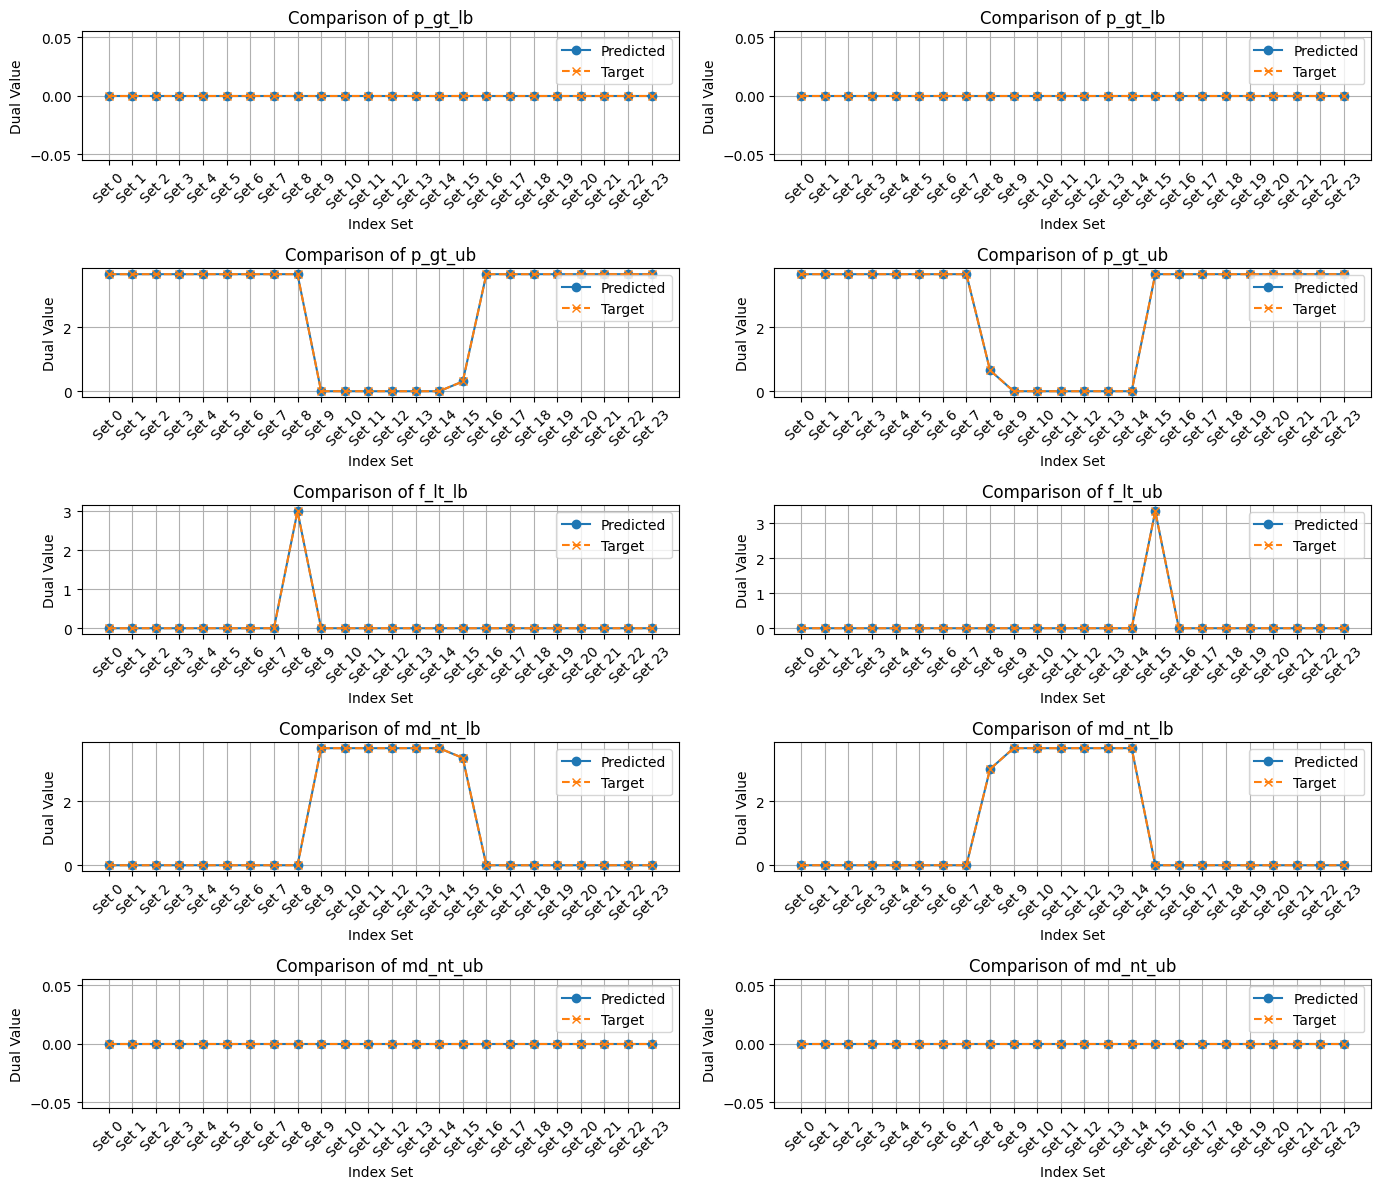

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define labels for the different dual variables
labels = ["p_gt_lb", "p_gt_lb", "p_gt_ub", "p_gt_ub",
          "f_lt_lb", "f_lt_ub", "md_nt_lb", "md_nt_lb",
          "md_nt_ub", "md_nt_ub"]

# Extract values for plotting
indices = np.arange(0, len(out_mu[0]), 10)
x_labels = [f"Set {i//10}" for i in indices]

out_values = np.array([[out_mu[1, i+j].item() for j in range(10)] for i in indices])
target_values = np.array([[target_mu[1, i+j].item() for j in range(10)] for i in indices])

# Create separate plots for each type
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()

for j in range(10):
    ax = axes[j]
    ax.plot(x_labels, out_values[:, j], marker='o', linestyle='-', label="Predicted")
    ax.plot(x_labels, target_values[:, j], marker='x', linestyle='--', label="Target")
    
    ax.set_ylabel("Dual Value")
    ax.set_xlabel("Index Set")
    ax.set_title(f"Comparison of {labels[j]}")
    ax.legend()
    ax.grid(True)
    ax.set_xticklabels(x_labels, rotation=45)

plt.tight_layout()
plt.show()